# U-Net: Classifying Atmospheric Layers With PCA Principle Axes

Andrew Liu (Last Modified: August 12, 2022)

Here is a 1-day long project on classifying atmospheric layers with PCA principle axes using a U-net architecture convolutional neural network. The PCA was fitted using the supplied transmission profiles. The U-net was implemented using TensorFlow, and there is also a Principle Component Analysis (PCA) that is implemented using sklearn.

As of the last modification date, all code blocks are working without errors.

## Imports

In [82]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from pathlib import Path
from itertools import combinations
from matplotlib.colors import SymLogNorm
from matplotlib.collections import LineCollection
 
import json
import re

import tensorflow as tf
import sklearn.decomposition as decomposition

%reload_ext autoreload
%autoreload 2
import ml

## Retrieve Data

### Data Path

The data path must be changed accordingly based on where the SAGE data is located.

In [83]:
path = Path('data')
sage = xr.open_mfdataset(path.glob('*.nc'))

### Filter Data

In [84]:
sage = sage.where((sage != sage.int_fill_value) & (sage != sage.flt_fill_value))

## Load JSON

In [85]:
with open('eventfilemod.json', 'r') as f:
    events = json.load(f)

## Form Dataset

NUM_CLASS is the number of labels we have and is either 2 or 3. If NUM_CLASS is 2, we are only classifying cloud or not cloud. If NUM_CLASS is 3, we add an additional label for aerosol layers. Since NaN values are not uniform across all wavelength channels, we choose not to classify NaN values here.

SHAPE specifies the dimension of the plot (in this case, we are working with 200 altitudes (0.5 km to 100.0 km in 0.5 km steps) and 61 time/event dimensions). 

OUT_SHAPE is the dimension of the plot being processed by the U-net. Each dimension must be a power of two to ensure that the input shape matches the output shape of the U-net after downscaling and upscaling, and in this case, the powers of two for the dimensions of each U-net input are 256 and 64. 

In [86]:
NUM_CLASS = 3
SHAPE = (200, 61)
OUT_SHAPE = (256, 64)

### Custom Colormap

In [87]:
colors1 = plt.cm.gist_heat(np.linspace(0., 1, 128))
colors2 = plt.cm.Greens(np.linspace(0, 1, 128))
colors3 = plt.cm.PiYG_r(np.linspace(0, 1, 128))

map_colors = (colors1, colors2, colors3)

colors = np.vstack(map_colors[0:NUM_CLASS - 1])
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)   

### Process Data

We need a new label generation function to create the labels we want.

In [88]:
def generateLabel(event, shape, num_class=2):
    """Returns a label corresponding to the event

    If the number of classes is greater than three, aerosol, cloud, and other layers are labeled. If the
    number of classes is two, then the labels are cloud and not cloud.

    Parameters
    ----------
    event : dict
        event information from event JSON file
    shape : 2-tuple of ints
        unpadded shape of input
    num_class : int, optional
        number of label classes, by default 2

    Returns
    -------
    2d list
        label corresponding to the event with specified shape
    """
    map = np.ones(shape[0])
    
    if num_class >= 3:
        aers = ml.getClassBounds(event['aerosols'])
        for aer in aers:
            if len(aer) == 1:
                map[int(aer[0] * 2 - 1)] = 2
            else:
                incr = int(aer[0] * 2 - 1)
                while incr <= (aer[-1] * 2 - 1):
                    map[incr] = 2
                    incr += 1
    
    clouds = ml.getClassBounds(event['clouds'])
    for alt in clouds:
        if len(alt) == 1:
            map[int(alt[0] * 2 - 1)] = 0
        else:
            incr = int(alt[0] * 2 - 1)
            while incr <= (alt[-1] * 2 - 1):
                map[incr] = 0
                incr += 1

    return map

Given that this was done in one day, there is only one channel (which is are principle axes).

FUTURE WORK: Add other channels, such as a tropopause altitude mask.

In [89]:
def process_data(data_class='training'):
    """Returns the processed data, labels, identifiers, and raw transmission profiles to be used for U-net

    Parameters
    ----------
    data_class : str, optional
        The class of data being processed, either 'training' or 'testing' (labels are only generated if the data class is 'training'), by default 'training'

    Returns
    -------
    list
        A list of four elements:
            data_, numpy array with processed channels with shape (number of components, altitude, time, channels) where altitude and time are padded.
            labels_, list of corresponding labels with shape (altitude, time, channels) where altitude and time are padded.
            ids_, list of identifiers for the labels and principle axes
            raw_data_, list of unmodified transmission profiles
    """
    data_, labels_, raw_data_ = [], [], []
    for e in events[data_class]:
        # Get time of event
        time = e['time']

        # Get transmission data matrix
        matrix = ml.getDataAsMatrix(time, sage)
        raw_data_.append(matrix)

        # Remove NaN values
        ml.deNaN(matrix, False)

        # Generate label for event
        if data_class == 'training': labels_.append(generateLabel(e, SHAPE, NUM_CLASS))

    # PCA
    N_COMPONENTS = len(raw_data_)                   # We simply use the maximum number of components to provide as much data as possible for the U-net

    data_, raw_data_ = np.array(data_), np.array(raw_data_)
    op_data_ = np.moveaxis(raw_data_, 2, 0)
    n_inputs, dim_0, dim_1 = op_data_.shape

    # Reshape and center the transmission profiles
    reshape_data = op_data_.reshape(n_inputs, dim_0 * dim_1)
    centered_data = reshape_data - reshape_data.mean(axis=0)
    centered_data -= centered_data.mean(axis=1).reshape(n_inputs, -1)

    # Fit the PCA
    estimator = decomposition.PCA(n_components=N_COMPONENTS, svd_solver='auto')
    estimator.fit(centered_data)

    # Get the principle axes
    est_data_ = estimator.components_

    # Shift each principle axis by the minimum value to remove any negative values, then scale
    # so that the maximum value is 1
    est_data_ += np.abs(np.min(est_data_, axis=1)).reshape(N_COMPONENTS, -1)
    est_data_ *= 1 / np.max(est_data_, axis=1).reshape(N_COMPONENTS, -1)
    est_data_ = np.moveaxis(est_data_.reshape(N_COMPONENTS, dim_0, dim_1), 1, 2)
    
    # Add the principle axes as data (with singular channel)
    data_ = np.array(ml.padAll(est_data_, OUT_SHAPE))[:, :, :, np.newaxis]
    # The labels are all identical for each principle axis
    if data_class == 'training': labels_ = np.repeat(ml.padMatrix(np.transpose(labels_), OUT_SHAPE)[np.newaxis, :, :], N_COMPONENTS, axis=0)
    # The identifiers are a number between 0 and the number of components - 1 inclusively
    ids_ = range(N_COMPONENTS)
    
    return [data_, labels_, ids_, raw_data_]

In [90]:
data_, labels_, ids_, raw_data_ = process_data()

Here is a code block for visualizing the processed data. The left plot is for the specified principle axis, and the right plot is the corresponding label. Note that for this work, 2 (green) now represents aerosol layers instead of NaN values since NaN is no longer being labeled. 0 (black) still represents cloud, and 1 (white) sitll represents other.

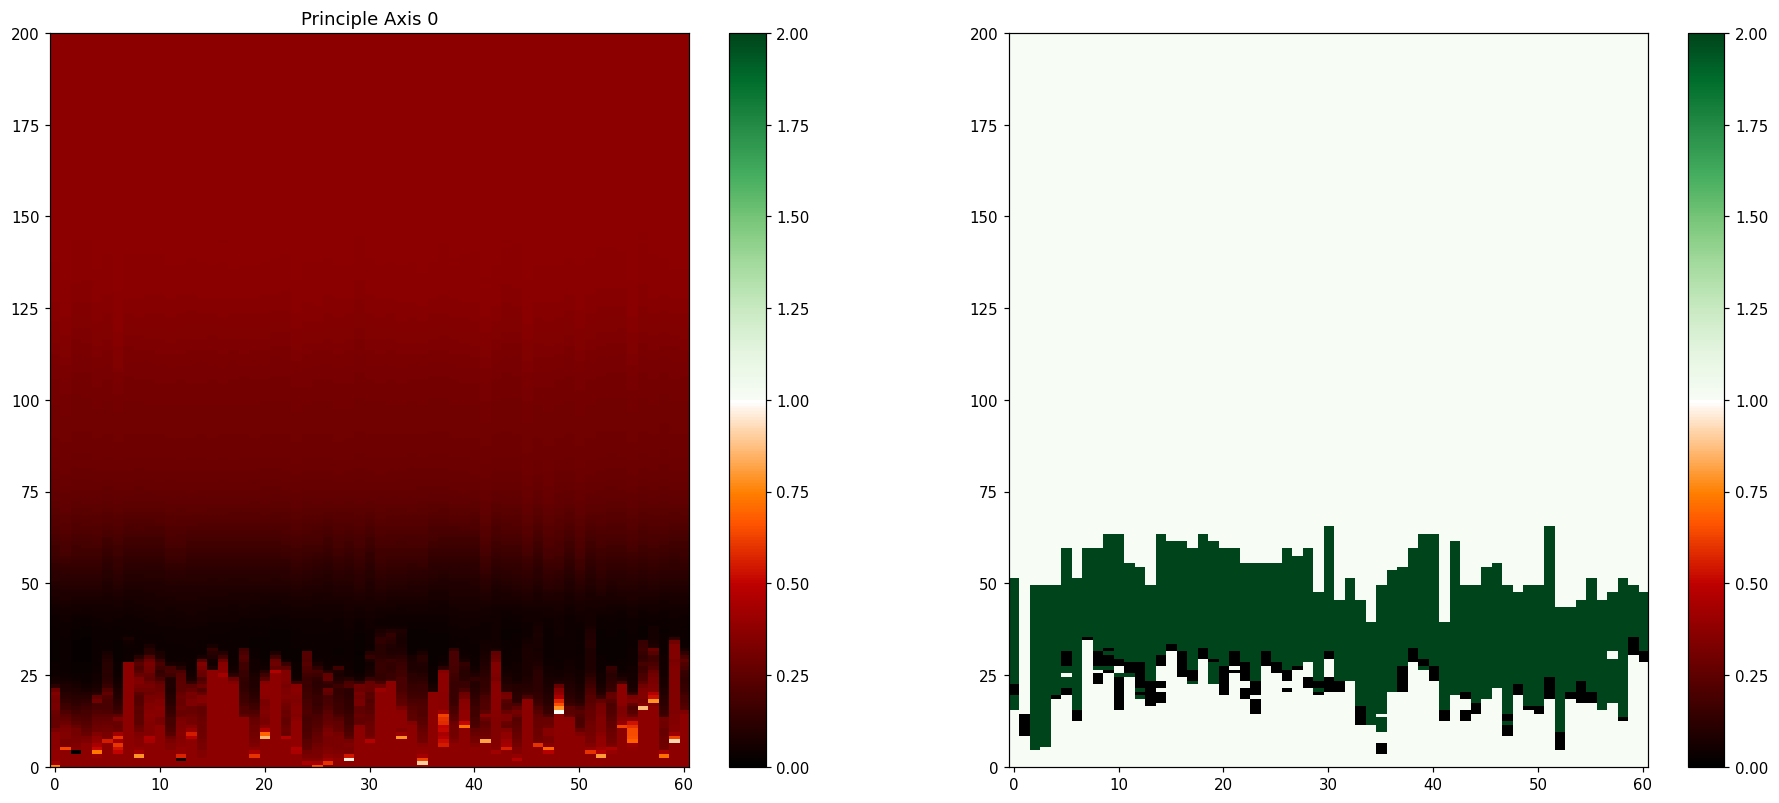

In [91]:
index = 0

f, ax = plt.subplots(1, 2, figsize=(21, 9), dpi=108)
#im = ax.imshow(data_[index, :, :, channel], vmin=0, vmax=NUM_CLASS - 1, aspect='auto', extent=[-0.5, 85.5, 0.25, 100.25], origin='lower', cmap=mymap)
im1 = ax[0].imshow(ml.truncMatrix(data_[index], SHAPE), vmin=0, vmax=NUM_CLASS - 1, aspect='auto', origin='lower', cmap=mymap)
#im = ax.imshow(ml.truncMatrix(labels_[index], SHAPE), vmin=0, vmax=NUM_CLASS - 1, aspect='auto', extent=[-0.5, 85.5, 0.25, 100.25], origin='lower', cmap=mymap)

im2 = ax[1].imshow(ml.truncMatrix(labels_[index], SHAPE), vmin=0, vmax=NUM_CLASS - 1, aspect='auto', origin='lower', cmap=mymap)

for a in ax:
    a.set_ylim(0, 200)

ax[0].set_title(f'Principle Axis {ids_[index]}')

f.colorbar(im1, ax=ax[0])
f.colorbar(im2, ax=ax[1])

### Experimentation With PCA

In [92]:
N_COMPONENTS_T = 32

nraw_data_ = np.moveaxis(raw_data_, 2, 0)
n_inputs, dim_0, dim_1 = nraw_data_.shape

reshape_data = nraw_data_.reshape(n_inputs, dim_0 * dim_1)
centered_data = reshape_data - reshape_data.mean(axis=0)
centered_data -= centered_data.mean(axis=1).reshape(n_inputs, -1)

#pca = decomposition.PCA(n_components=n_components, svd_solver='randomized')
pca = decomposition.PCA(n_components=N_COMPONENTS_T, svd_solver='auto')
pca_data_ = pca.inverse_transform(pca.fit_transform(centered_data))

pca_data_ += np.abs(np.min(pca_data_, axis=1)).reshape(n_inputs, -1)
pca_data_ *= 1 / np.max(pca_data_, axis=1).reshape(n_inputs, -1)
pca_data_ = pca_data_.reshape(n_inputs, dim_0, dim_1)
var_data = pca.noise_variance_

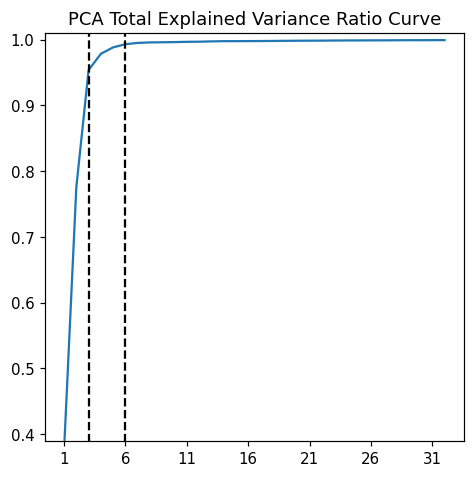

In [93]:
f, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=108)

x = np.array(range(N_COMPONENTS_T)) + 1
y = np.array(pca.explained_variance_ratio_) * -1 + 1

ax.plot(x, y)
ax.vlines(6, ymin=-0.2, ymax=1.2, linestyle='--', color='black')
ax.vlines(3, ymin=-0.2, ymax=1.2, linestyle='--', color='black')

ax.set_title('PCA Total Explained Variance Ratio Curve')
ax.set_ylim((0.39, 1.01))
ax.set_xticks(range(1, N_COMPONENTS_T + 1, 5));

Here is a visualization of the PCA's principle axes. Specify ROW and COL as needed to see the principle axes as needed.

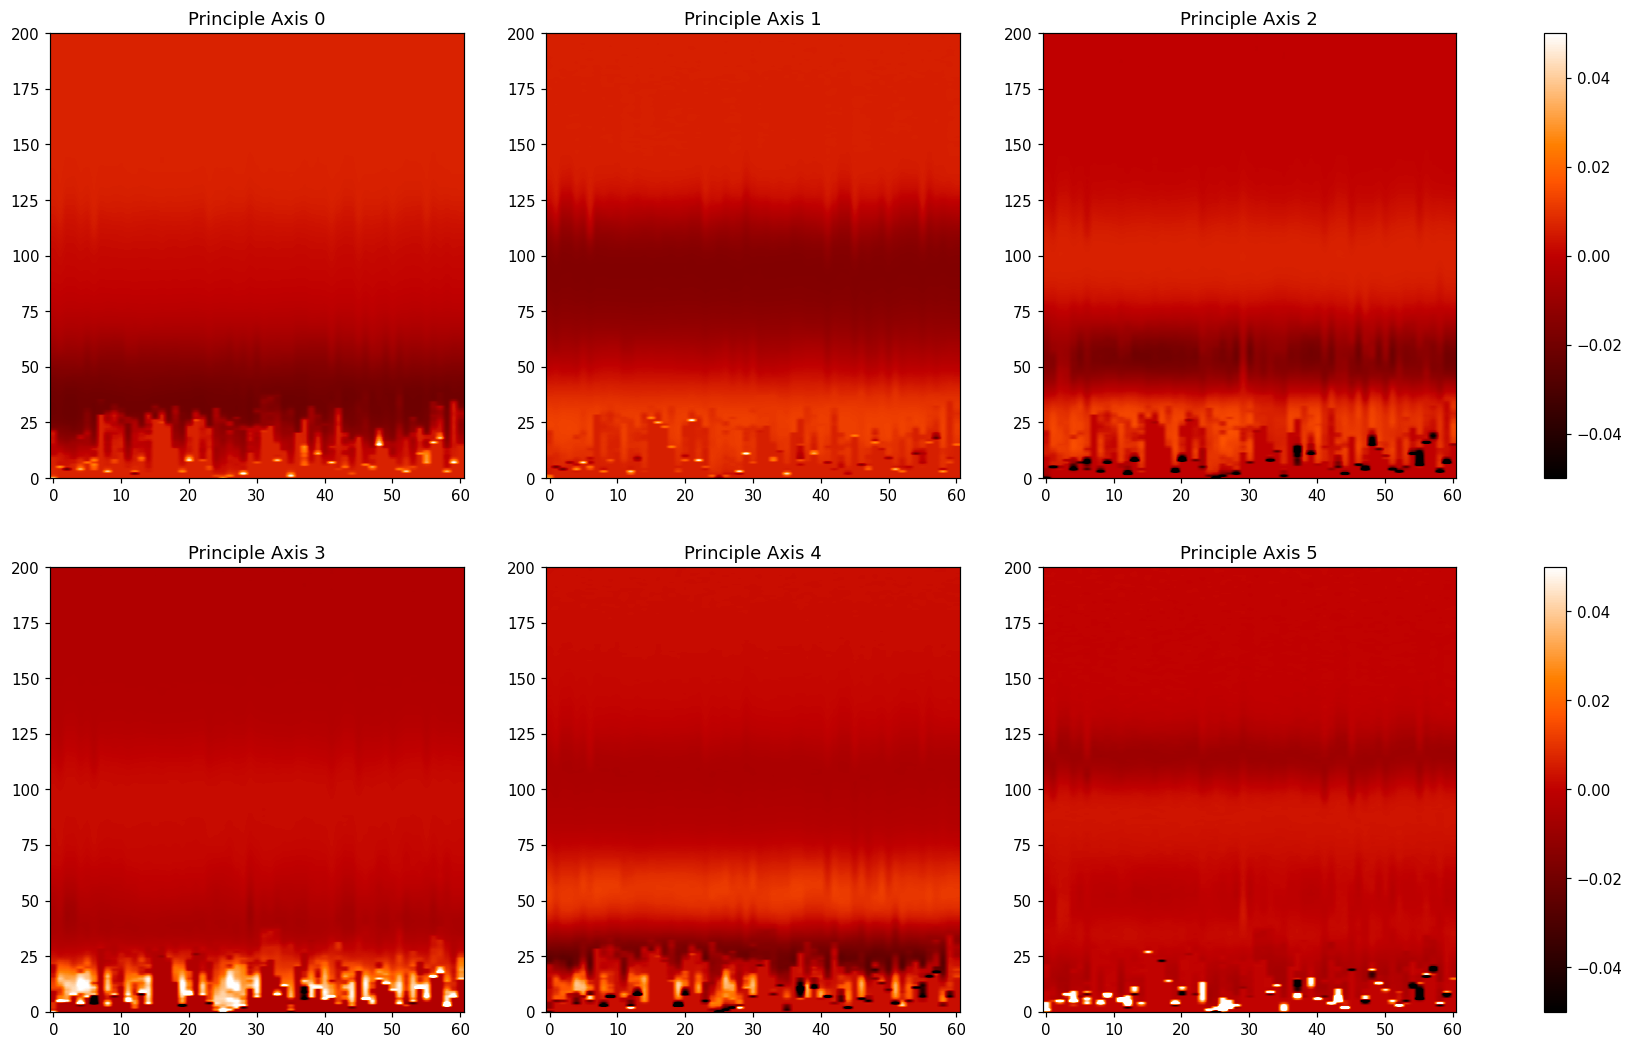

In [94]:
ROW, COL = 2, 3

#plot_data = pca.inverse_transform(pca.transform(centered_data)).reshape(N_COMPONENTS_T, dim_0, dim_1)
p_axes = np.moveaxis(pca.components_.reshape(N_COMPONENTS_T, dim_0, dim_1), 1, 2)

f, ax = plt.subplots(ROW, COL, figsize=(21, 6*ROW), dpi=108)
k = 0
for i in range(ROW):
    for j in range(COL):
        a = ax[i, j]
        if k < len(p_axes):
            im = a.imshow(p_axes[k], vmin=-0.05, vmax=0.05, aspect='auto', origin='lower', cmap='gist_heat')

        a.set_ylim(0, 200)
        a.set_title(f'Principle Axis {k}')
        k += 1
    
    f.colorbar(im, ax=ax[i])

### Back to Data Processing

Here, we shuffle the data, labels, and time identifiers using a seed, then split them into training datasets and validation datasets for the U-net to use.
The validation split is currently 20%, so about 20% of all available data is used for validation and 80% is used for training.

In [95]:
SEED = 2000
tf.random.shuffle(data_, seed=SEED)
tf.random.shuffle(labels_, seed=SEED)
tf.random.shuffle(ids_, seed=SEED)

val_split = 0.2
split_index = len(data_) - int(np.ceil(len(data_) * val_split))

train_data = np.array(data_[:split_index]).astype("float32")
train_labels = np.array(labels_[:split_index]).astype("float32")
train_ids = ids_[:split_index]

val_data = np.array(data_[split_index:]).astype("float32")
val_labels = np.array(labels_[split_index:]).astype("float32")
val_ids = ids_[split_index:]

In [96]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))

In [97]:
BATCH_SIZE = 2
SHUFFLE_BUFFER_SIZE = 16

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

## U-net

Here, we initialize the model based on the shape of the data (which is in (altitude, time, channel) dimensions) and the number of classes. As more channels and/or labels are added, create_unet should initialize the model with the changes accordingly.

In [98]:
model = ml.create_unet(data_.shape[1:], NUM_CLASS)

In [99]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [100]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30
)

Epoch 1/30
24/24 [==============================] - 6s 111ms/step - loss: 0.7691 - accuracy: 0.8657 - val_loss: 0.9836 - val_accuracy: 0.6498
Epoch 2/30
24/24 [==============================] - 2s 68ms/step - loss: 0.1384 - accuracy: 0.9484 - val_loss: 1.3700 - val_accuracy: 0.6523
Epoch 3/30
24/24 [==============================] - 2s 66ms/step - loss: 0.0963 - accuracy: 0.9616 - val_loss: 1.6860 - val_accuracy: 0.6524
Epoch 4/30
24/24 [==============================] - 2s 74ms/step - loss: 0.0782 - accuracy: 0.9689 - val_loss: 1.9133 - val_accuracy: 0.6525
Epoch 5/30
24/24 [==============================] - 2s 68ms/step - loss: 0.0646 - accuracy: 0.9744 - val_loss: 2.0893 - val_accuracy: 0.6525
Epoch 6/30
24/24 [==============================] - 2s 67ms/step - loss: 0.0523 - accuracy: 0.9790 - val_loss: 2.1878 - val_accuracy: 0.6509
Epoch 7/30
24/24 [==============================] - 2s 72ms/step - loss: 0.0424 - accuracy: 0.9834 - val_loss: 2.3958 - val_accuracy: 0.6510
Epoch 8/30
2

### Model Performance Plot

Here, we visualize the training and validation accuracies as a function of the epoch. To change the y limits, adjust the function plot_perf in the ml module. The validation accuracy tends to stagnate at around 65% before shooting upwards to 99% after 20 or so epochs. 

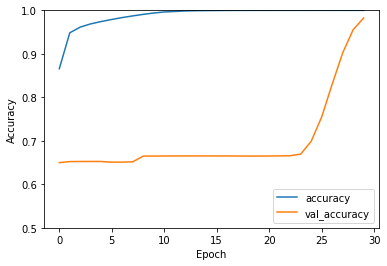

In [101]:
ml.plot_perf(history)

## Model Predictions

### Predictions For Validation Data

In [102]:
predictions = np.array(model.predict(val_data))

1/1 [==============================] - 1s 733ms/step


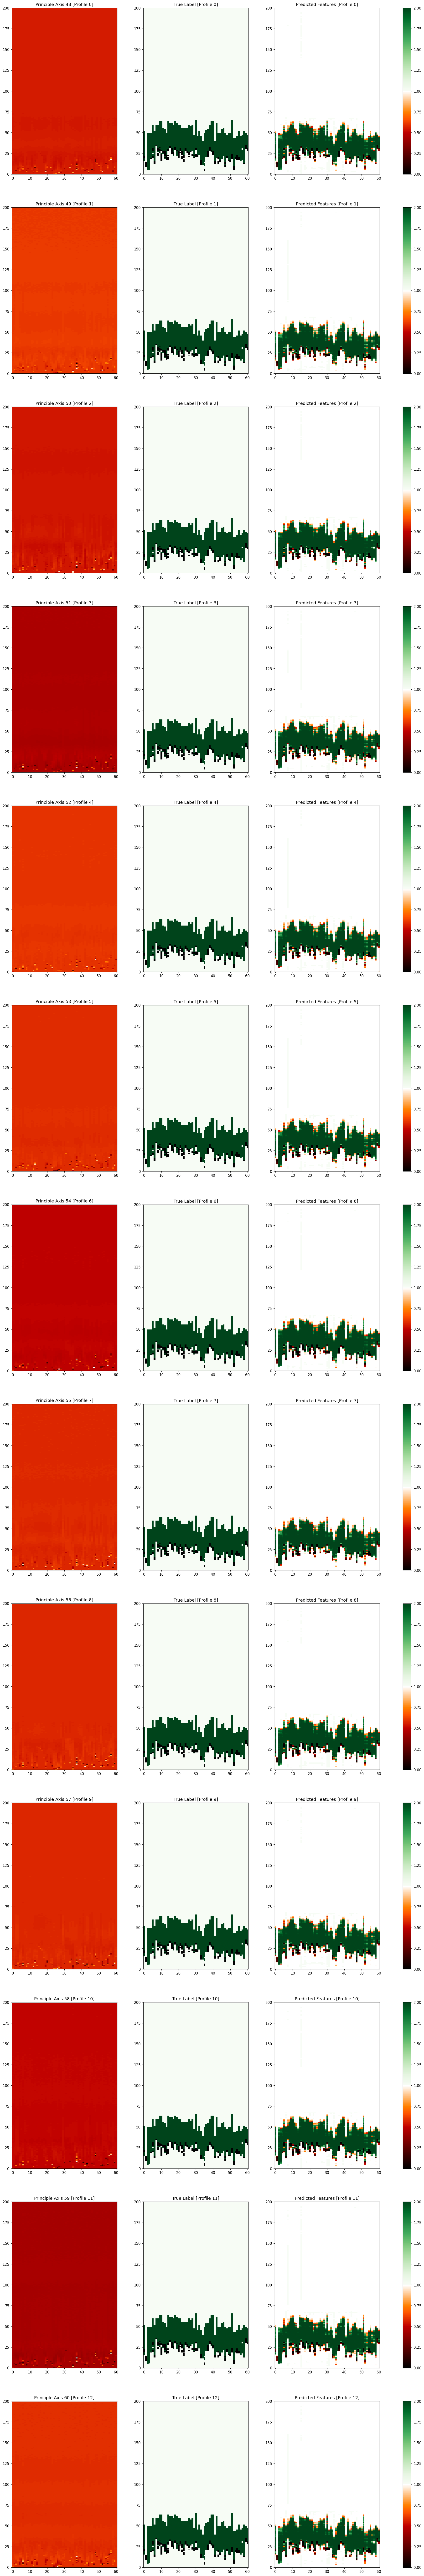

In [103]:
NUM_VAL = len(val_data)
COLOR_MAP = mymap

val_classified_outputs = ml.multiclassifier(predictions, NUM_CLASS)

f, ax = plt.subplots(NUM_VAL, 3, figsize=(21, 9 * NUM_VAL), dpi=108)
f.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=0.25)
#cax = f.add_axes([0.925, 0.05, 0.025, 0.85])

for i in range(NUM_VAL):
    ax[i, 0].imshow(ml.truncMatrix(val_data[i, :, :, 0], SHAPE), vmin=0, vmax=NUM_CLASS - 1, aspect='auto', origin='lower', cmap=COLOR_MAP)
    ax[i, 0].set_title(f'Principle Axis {val_ids[i]} [Profile {i}]')

    ax[i, 1].imshow(ml.truncMatrix(val_labels[i, :, :], SHAPE), vmin=0, vmax=NUM_CLASS - 1, aspect='auto', origin='lower', cmap=COLOR_MAP)
    ax[i, 1].set_title(f'True Label [Profile {i}]')
    
    #ml.truncMatrix(val_classified_outputs[i], SHAPE)
    #ml.truncMatrix(predictions[i, :, :, 1], SHAPE)
    im = ax[i][2].imshow(ml.truncMatrix(val_classified_outputs[i], SHAPE), vmin=0, vmax=NUM_CLASS - 1, aspect='auto', origin='lower', cmap=COLOR_MAP)
    
    ax[i, 2].set_title(f'Predicted Features [Profile {i}]')

    for j in [0, 1, 2]:
        ax[i, j].set_ylim(0, 200)

    f.colorbar(im, ax=ax[i])
#f.colorbar(im, cax=cax)

Here, since all of the predicted labels should technically be the same, I take the mean and median of all of the predicted labels.

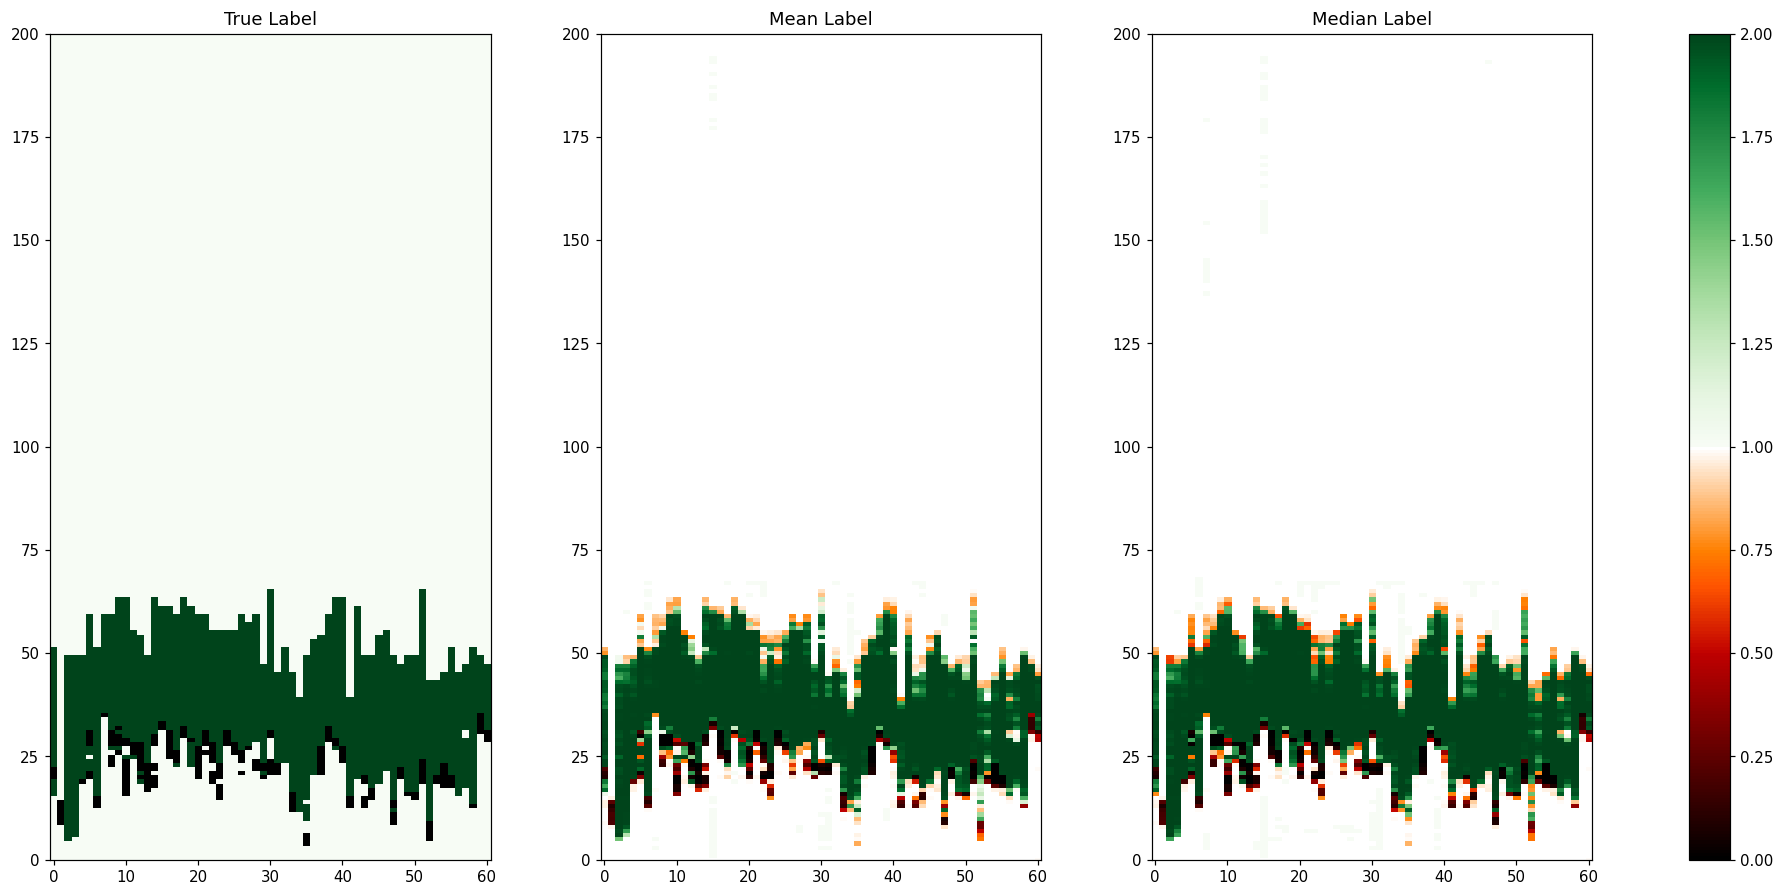

In [104]:
val_classified_outputs = ml.multiclassifier(predictions, NUM_CLASS)

v_mean = np.mean(val_classified_outputs, axis=0)
v_median = np.median(val_classified_outputs, axis=0)

COLOR_MAP = mymap

f, ax = plt.subplots(1, 3, figsize=(21, 9), dpi=108)
f.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=0.25)

ax[0].imshow(ml.truncMatrix(val_labels[0], SHAPE), vmin=0, vmax=NUM_CLASS - 1, aspect='auto', origin='lower', cmap=COLOR_MAP)
ax[0].set_title('True Label')

ax[1].imshow(ml.truncMatrix(v_mean, SHAPE), vmin=0, vmax=NUM_CLASS - 1, aspect='auto', origin='lower', cmap=COLOR_MAP)
ax[1].set_title('Mean Label')
    
im = ax[2].imshow(ml.truncMatrix(v_median, SHAPE), vmin=0, vmax=NUM_CLASS - 1, aspect='auto', origin='lower', cmap=COLOR_MAP)
ax[2].set_title('Median Label')

for i in [0, 1, 2]:
    ax[i].set_ylim(0, 200)

f.colorbar(im, ax=ax)

### Predictions For Testing Data

In [105]:
testing_data, _, testing_ids, testing_raw_data_ = process_data('testing')

In [106]:
test_predictions = np.array(model.predict(testing_data))

1/1 [==============================] - 0s 457ms/step


Here, we see the predictions for the testing dataset. It is clear that more work must be done due to the high variability of the labels when they should all be approximately the same.

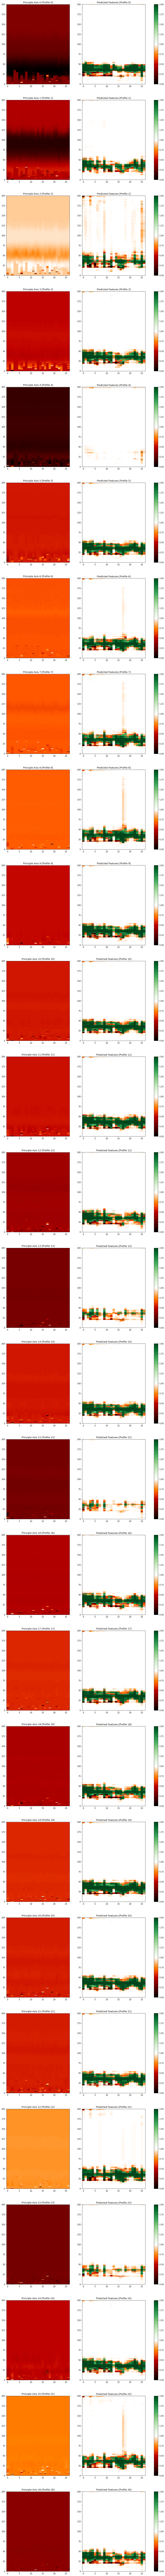

In [107]:
NUM_DATA = len(testing_data)
COLOR_MAP = mymap
TEST_SHAPE = (200, 27)

test_classified_outputs = ml.multiclassifier(test_predictions, NUM_CLASS)

f, ax = plt.subplots(NUM_DATA, 2, figsize=(16, 9 * NUM_DATA), dpi=108)
for i in range(NUM_DATA):
    ax[i, 0].imshow(ml.truncMatrix(testing_data[i, :, :, 0], TEST_SHAPE), vmin=0, vmax=NUM_CLASS - 1, aspect='auto', origin='lower', cmap=COLOR_MAP)
    ax[i, 0].set_title(f'Principle Axis {testing_ids[i]} [Profile {i}]')

    im = ax[i, 1].imshow(ml.truncMatrix(test_classified_outputs[i], TEST_SHAPE), vmin=0, vmax=NUM_CLASS - 1, aspect='auto', origin='lower', cmap=COLOR_MAP)
    ax[i, 1].set_title(f'Predicted Features [Profile {i}]')

    for j in [0, 1]:
        ax[i, j].set_ylim(0, 200)

    f.colorbar(im, ax=ax[i])

We take the mean and median of all of the predicted labels.

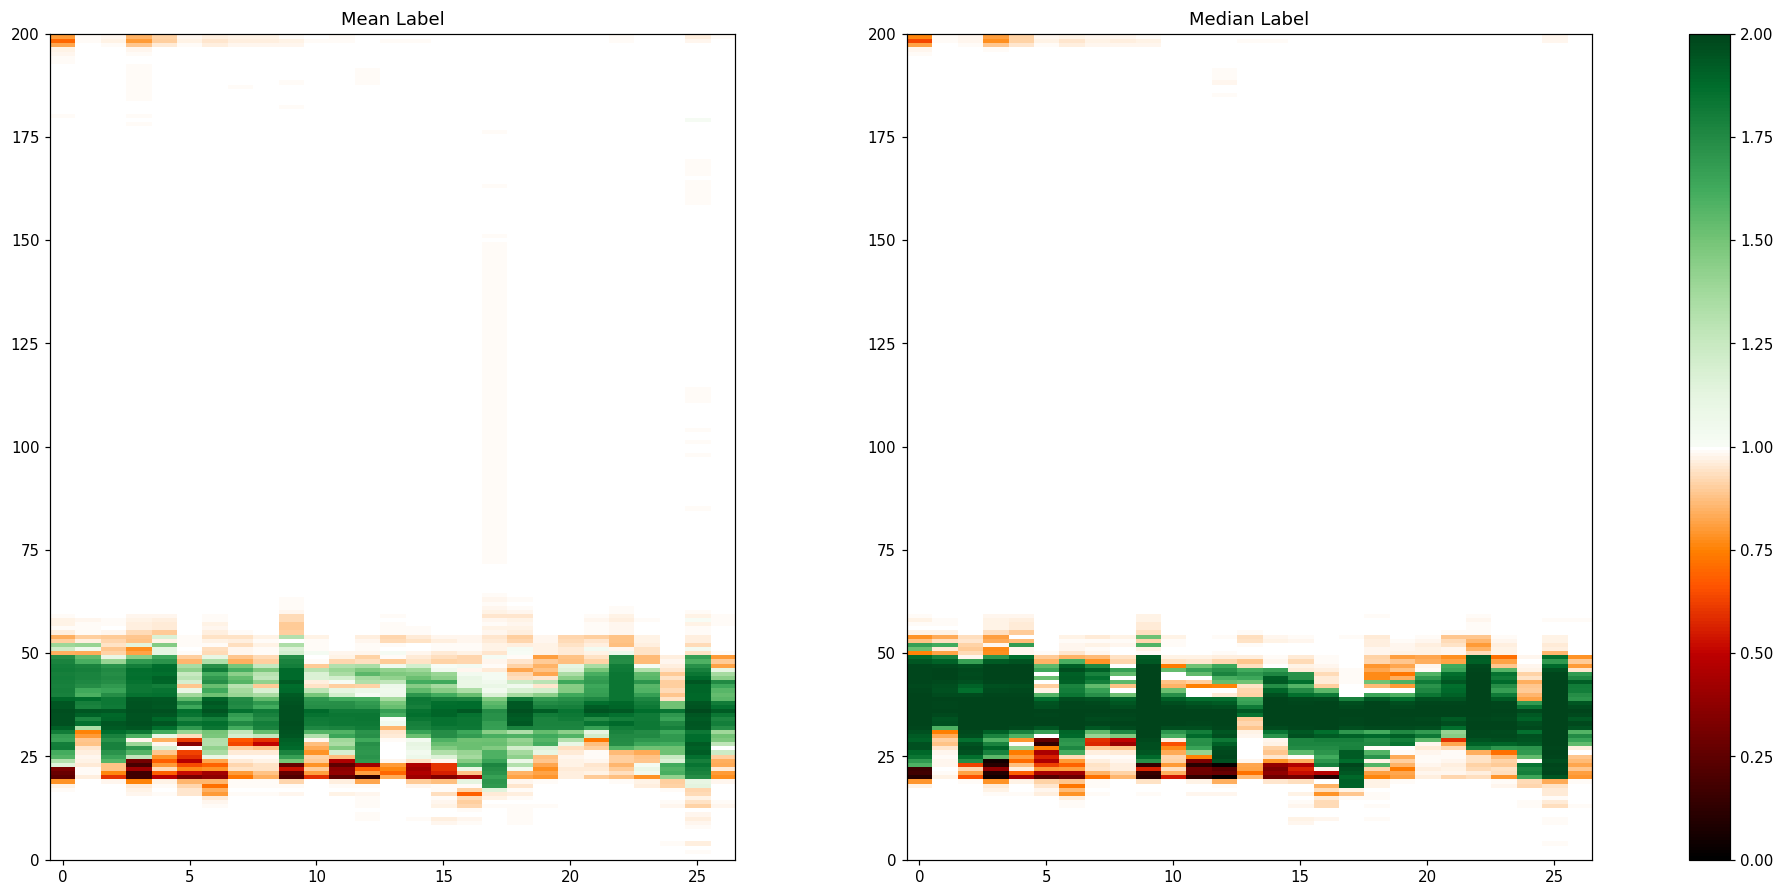

In [108]:
test_classified_outputs = ml.multiclassifier(test_predictions, NUM_CLASS)

t_mean = np.mean(test_classified_outputs, axis=0)
t_median = np.median(test_classified_outputs, axis=0)

COLOR_MAP = mymap

f, ax = plt.subplots(1, 2, figsize=(21, 9), dpi=108)
f.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=0.25)

ax[0].imshow(ml.truncMatrix(t_mean, TEST_SHAPE), vmin=0, vmax=NUM_CLASS - 1, aspect='auto', origin='lower', cmap=COLOR_MAP)
ax[0].set_title('Mean Label')
    
im = ax[1].imshow(ml.truncMatrix(t_median, TEST_SHAPE), vmin=0, vmax=NUM_CLASS - 1, aspect='auto', origin='lower', cmap=COLOR_MAP)
ax[1].set_title('Median Label')

for i in [0, 1]:
    ax[i].set_ylim(0, 200)

f.colorbar(im, ax=ax)

## Convolution Layer Visualization

Simply remove the triple quotes to get these code blocks working again.

### Filter Visualization

In [109]:
"""for layer in [model.layers[1]]:
    if 'conv' in layer.name: # and len(layer.name) <= 8:
        weights = layer.get_weights()[0]
        
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)
        print(layer.name, filters.shape)
        filter_cnt=1
        
        f, ax = plt.subplots(filters.shape[3], filters.shape[2], figsize=(16, 12), dpi=108)
        for i in range(filters.shape[-1]):
            filt=filters[:, :, :, i]

            for j in range(filters.shape[2]):
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
                ax[i, j].imshow(filt[:, :, j], cmap='gist_heat')

            filter_cnt+=1""";

### Feature Map Visualization

In [110]:
"""conv_blocks = []
for label_i in range(len(model.layers)):
    layer = model.layers[label_i]

    if 'conv' in layer.name and (re.compile('conv2d_\d').match(layer.name) or layer.name == 'conv2d'):
        print(label_i, layer.name, layer.output.shape)
        conv_blocks.append(label_i)
    
    label_i += 1

print(conv_blocks)""";

In [111]:
"""visual_data = np.expand_dims(train_data[0], axis=0)

outputs = [model.layers[i].output for i in conv_blocks]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = outputs)

feature_maps = visualization_model.predict(visual_data)

NUM_COLS = 8
NUM_ROWS = 4

iter = 0
for fmap in feature_maps[:-1]:
    ix = 1
    f, ax = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(21, 6 * NUM_ROWS), facecolor='w', dpi=108)
    f.suptitle(f'{model.layers[conv_blocks[iter]].name} {fmap.shape}', size=20)
    f.tight_layout()
    f.subplots_adjust(top=0.95)
    for i in range(NUM_ROWS):
        for j in range(NUM_COLS):
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
            ax[i][j].imshow(np.flipud(fmap[0, :, :, ix - 1]), cmap='gist_heat')
            ax[i][j].set_title(f'{i * NUM_COLS + j}', size=15)
            ix += 1
    iter += 1

NUM_ROWS = 1
NUM_COLS = NUM_CLASS

ix = 1
f, ax = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(21, 6 * NUM_ROWS), facecolor='w', dpi=108)
f.suptitle(f'{model.layers[conv_blocks[iter]].name} {feature_maps[-1].shape}', size=20)
f.tight_layout()
for i in range(NUM_COLS):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(np.flipud(feature_maps[-1][0, :, :, ix - 1]), cmap='gist_heat')
    ax[i].set_title(f'{i}', size=15)
    ix += 1""";